# Multi-Class Text Classification with Scikit-Learn
### Given a list of ingredients, can you tell the cuisine type? --- supervised learning with labeled text data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix


os.chdir('/Users/chengchen/Desktop/Insight/19C/')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Data exploration
#### read and preview data

In [2]:
data_dir = 'Challenge_Recipe2Cuisine/recipies.json'
df = pd.read_json(data_dir)

df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


#### Understanding the number and distribution of cuisine types

In [3]:
df.shape

(39774, 3)

In [4]:
df['ingredients'] = df['ingredients'].apply(', '.join)
df.cuisine.unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

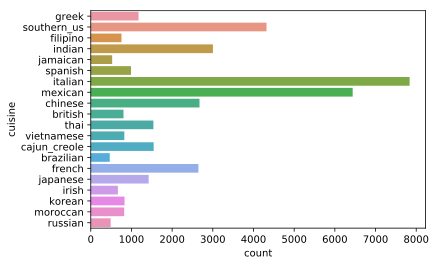

In [5]:
ax = sns.countplot(y="cuisine", data=df)

* The samples are imbalanced, as shown in the plot above. Conventional algorithms are often biased towards the majority class, not taking the data distribution into consideration. If we care a lot about correctly classifying the minor categories, we could undersample or oversample each class. However, in this specific case, I care about overall precision of predicting cuisine type, and the majority classes might be of our greatest interest. Therefore, I leave the unbalanced data as it is.

#### Indexing cuisine types and creating dictionaries for future use

In [6]:
df['cuisine_id'] = df['cuisine'].factorize()[0]
cuisine_id_df = df[['cuisine', 'cuisine_id']].drop_duplicates().sort_values('cuisine_id')
cuisine_to_id = dict(cuisine_id_df.values)
id_to_cuisine = dict(cuisine_id_df[['cuisine_id', 'cuisine']].values)
df.head()

,id,cuisine,ingredients,cuisine_id
0,10259,greek,"romaine lettuce, black olives, grape tomatoes,...",0
1,25693,southern_us,"plain flour, ground pepper, salt, tomatoes, gr...",1
2,20130,filipino,"eggs, pepper, salt, mayonaise, cooking oil, gr...",2
3,22213,indian,"water, vegetable oil, wheat, salt",3
4,13162,indian,"black pepper, shallots, cornflour, cayenne pep...",3


## Text Representation
* I will use tf-idf to represent the text in vector format, tf-idf is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.
* $\mathrm{tfidf} = \mathrm{tf} \times \mathrm{idf}$, where tf stands for term frequency, and idf stands for inverse document frequency
* $\mathrm{tf}$: In this example of predicting cuisine given ingredients, it makes sense to use a boolean frequency for tf: whether the ingredient list contains a certain ingredient. Formulated as $\mathrm{tf(t,d)} = 1$ if term $t$ occurs in document $d$ and 0 otherwise.
* $\mathrm{idf} = \log \frac{N}{n_t}$, where $N$ is the total number of documents in the corpus, ${n_t}$ is the number of documents where the term $t$ appears (i.e., $\mathrm{tf(t,d)}>0$)

In [7]:
tfidf = TfidfVectorizer(binary = True, sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.ingredients).toarray()
labels = df.cuisine_id
features.shape

(39774, 17805)

* Each of 39774 cuisines are represented by 17805 features,  representing the tf-idf score for different unigrams and bigrams

### Finding the terms that are the most correlated with each of the products
* Chi-square Test for Feature Extraction: 
$$\chi^2 = \frac{\mathrm{(Observed\ frequency\ -\ Expected \ frequency)}^2}{\mathrm{Expected \ frequency}}$$
where **observed frequency** = No. of observations of class, <br>
**Expected frequency** = No. of expected observations of class if there was no relationship between the feature and the target. <br>


In [19]:
from sklearn.feature_selection import chi2
import numpy as np
N = 6
for cuisine, cuisine_id in sorted(cuisine_to_id.items()):
  features_chi2 = chi2(features, labels == cuisine_id)
  indices = np.argsort(features_chi2[1])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(cuisine))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[:N])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[:N])))

# 'brazilian':
  . Most correlated unigrams:
. cachaca
. açai
. manioc
. granola
. sweetened
. tapioca
  . Most correlated bigrams:
. cachaca lime
. sugar cachaca
. lime cachaca
. chocolate sprinkles
. ice lime
. manioc flour
# 'british':
  . Most correlated unigrams:
. stilton
. suet
. marmite
. mincemeat
. jam
. haddock
  . Most correlated bigrams:
. beef drippings
. stilton cheese
. golden syrup
. plain flour
. raspberry jam
. double cream
# 'cajun_creole':
  . Most correlated unigrams:
. cajun
. creole
. andouille
. seasoning
. celery
. sausage
  . Most correlated bigrams:
. cajun seasoning
. creole seasoning
. andouille sausage
. smoked sausage
. green bell
. file powder
# 'chinese':
  . Most correlated unigrams:
. soy
. chinese
. sesame
. starch
. shaoxing
. hoisin
  . Most correlated bigrams:
. soy sauce
. sesame oil
. corn starch
. hoisin sauce
. shaoxing wine
. oyster sauce
# 'filipino':
  . Most correlated unigrams:
. calamansi
. lumpia
. peppercorn
. jackfruit
. belly
. pati

### Naive bayes classifier --- baseline model

In [11]:
X, y = df.ingredients, df.cuisine
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)
tfidf = TfidfVectorizer(binary = True, sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

* Try some Chinese recipe! (just for fun)

In [12]:
print('prediction result for 番茄炒蛋')
print(clf.predict(tfidf.transform(["oil, tomato, egg, salt, sugar, green onion"])))

prediction result for 番茄炒蛋
['italian']


In [13]:
print('prediction result for 番茄炒蛋')
print(clf.predict(tfidf.transform(["oil, tomato, egg, salt, sugar, green onion, ginger, garlic"])))

prediction result for 番茄炒蛋
['chinese']


In [14]:
print('prediction result for 番茄土豆牛腩煲')
print(clf.predict(tfidf.transform(["oil, tomato, beef, soy sauce, sugar, water, potato, green onion, ginger, garlic"])))

prediction result for 番茄土豆牛腩煲
['chinese']


* Naive bayes classifier works OK. Errors also make sense. 
<br>

## Model Selection
<br>

* select model from random forest classifier, linear support vector machine, random forest, multinomial naive bayes

/Users/chengchen/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/chengchen/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


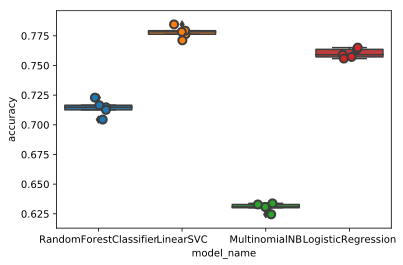

In [15]:
X, y = df.ingredients, df.cuisine_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 15)
tfidf = TfidfVectorizer(binary = True, sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

models = [
    RandomForestClassifier(n_estimators=100, max_features=0.5, min_samples_leaf= 2, n_jobs=-1, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index = range(CV*len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tfidf, y_train, scoring = 'accuracy', cv = CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns = ['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [16]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.777934
LogisticRegression        0.760143
MultinomialNB             0.630444
RandomForestClassifier    0.714230
Name: accuracy, dtype: float64

* LinearSVC works the best, therefore use it on the test set <br>


## Model Evaluation
### Accuracy of testing data

In [18]:
model = LinearSVC()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

print('accuracy for testing data', sum(y_pred==y_test)/len(y_test))

accuracy for testing data 0.7792583280955374


### Confusion Matrix

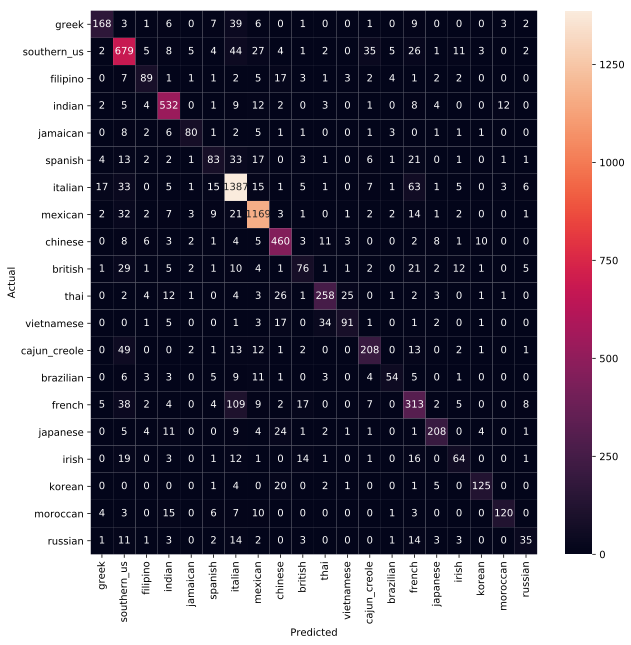

In [20]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=cuisine_id_df.cuisine.values, yticklabels=cuisine_id_df.cuisine.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('Submission_Week 6/confusion_matrix.png')
plt.show()
